# Dat550 Project

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from textblob import TextBlob
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, Dense, GlobalMaxPool1D, Embedding, TextVectorization, MaxPooling1D, LSTM, Adam, Dropout, GlobalMaxPooling1D


c:\Users\Ninh Bao\Documents\skole\DAT550-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading Functions

In [2]:
# Load articles
def load_articles(filepath):
    articles = []
    with open(filepath, "r", encoding="UTF-8") as f:
        for line in f:
            data = json.loads(line)
            text = data["title"] + " " + data["content"]
            articles.append({
                "id": data["id"],
                "text": text
            })
    return articles

# Load labels
def load_labels(filepath):
    labels = []
    with open(filepath, "r", encoding="UTF-8") as f:
        for line in f:
            data = json.loads(line)
            labels.append({
                "id": str(data["id"]).zfill(7),  # Zero-pad to match article IDs
                "label": 1 if data["hyperpartisan"] else 0
            })
    return labels

## File paths

In [67]:
# df = pd.read_xml("Webis-data/extracted/ground-truth-training-byarticle-20181122.xml")
# df.to_json("preprocessing/data/ground-truth-training-byarticle.jsonl",orient="records",lines=True)

# df = pd.read_xml("Webis-data/extracted/ground-truth-training-bypublisher-20181122.xml")
# df.to_json("preprocessing/data/ground-truth-training-bypublisher.jsonl",orient="records",lines=True)

# df = pd.read_xml("Webis-data/extracted/ground-truth-test-bypublisher-20181212.xml")
# df.to_json("preprocessing/data/ground-truth-test-bypublisher.jsonl",orient="records",lines=True)

# df = pd.read_xml("Webis-data/extracted/ground-truth-test-byarticle-20181207.xml")
# df.to_json("preprocessing/data/ground-truth-test-byarticle.jsonl",orient="records",lines=True)

In [3]:
train_articles_path = "preprocessing/data/articles-training-byarticle.jsonl"
train_labels_path = "preprocessing/data/ground-truth-training-byarticle.jsonl"
test_articles_path  = "preprocessing/data/articles-test-byarticle.jsonl"
test_labels_path    = "preprocessing/data/ground-truth-test-byarticle.jsonl"

## Load and Merge Training Data

In [4]:
train_articles_df = pd.DataFrame(load_articles(train_articles_path))
train_labels_df   = pd.DataFrame(load_labels(train_labels_path))
train_articles_df["id"] = train_articles_df["id"].astype(str)
# Merge training data on 'id'
train_df = pd.merge(train_articles_df, train_labels_df, on="id")
# For training, we only need the text and the label

# Add publication data and such for more feature?

texts_train = train_df["text"].tolist()
labels_train = train_df["label"].values

print("Training data samples:", len(texts_train))

Training data samples: 645


## Load and Merge Test Data

In [5]:
test_articles_df = pd.DataFrame(load_articles(test_articles_path))
test_labels_df   = pd.DataFrame(load_labels(test_labels_path))
test_articles_df["id"] = test_articles_df["id"].astype(str)
# Merge test data on 'id'
test_df = pd.merge(test_articles_df, test_labels_df, on="id")
texts_test = test_df["text"].tolist()
labels_test = test_df["label"].values

print("Test data samples:", len(texts_test))

Test data samples: 628


## Preprocessing the Text with TextVectorization

In [6]:
max_tokens = 10000          # Maximum vocabulary size
max_sequence_length = 200   # Maximum sequence length (adjust as needed)

vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(texts_train)

# Vectorize the texts. The output is a tensor of shape (num_samples, max_sequence_length)
X_train = vectorize_layer(texts_train)
X_test  = vectorize_layer(texts_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (645, 200)
X_test shape: (628, 200)


## Build the Convolutional Neural Network (CNN) Model 

In [7]:
model = Sequential([
    Input(shape=(max_sequence_length,)),
    # Embedding layer maps integer sequences to dense vectors.
    Embedding(input_dim=max_tokens, output_dim=128),
    Conv1D(filters=100, kernel_size=3, activation='relu'),
    GlobalMaxPool1D(),
    # Fully connect the network
    Dense(units=64, activation='relu'),
    # Output layer
    Dense(units=1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 198, 100)       │        38,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,325,029 (5.05 MB)

 Trainable params: 1,325,029 (5.05 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [8]:
history = model.fit(X_train, labels_train, batch_size=16, epochs=10, validation_split=0.2)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5829 - loss: 0.6727 - val_accuracy: 0.7209 - val_loss: 0.6140
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6557 - loss: 0.5999 - val_accuracy: 0.7209 - val_loss: 0.6002
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7872 - loss: 0.4633 - val_accuracy: 0.6899 - val_loss: 0.5976
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9973 - loss: 0.2212 - val_accuracy: 0.7442 - val_loss: 0.5529
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0508 - val_accuracy: 0.7442 - val_loss: 0.5491
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0127 - val_accuracy: 0.7287 - val_loss: 0.5630
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.7442 - val_loss: 0.5706
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.7442 - v

## Evaluate & Predict on Test Data

Final Evaluation - Loss: 0.5891, Accuracy: 0.6815
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


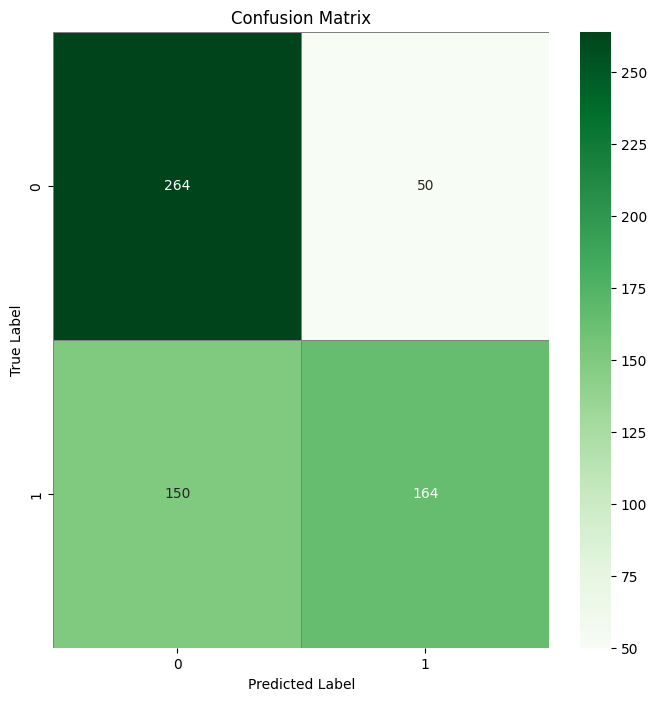

In [9]:
# Evaluate the model on test data and print loss and accuracy:
loss_eval, acc_eval = model.evaluate(X_test, labels_test, verbose=0)
print(f"Final Evaluation - Loss: {loss_eval:.4f}, Accuracy: {acc_eval:.4f}")

# Generate predictions: convert probabilities to 0 or 1 by thresholding at 0.5
predictions = model.predict(X_test)
pred_y = (predictions >= 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(labels_test, pred_y)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt='d', linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Hypermeter tuning

In [ ]:
# 1. Define your hypermodel
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(max_sequence_length,)))
    
    # Tune embedding output dim
    model.add(Embedding(input_dim=max_tokens, output_dim=hp.Choice('embedding_dim', [64, 128, 256])))

    # Tune Conv1D
    model.add(Conv1D(
        filters=hp.Choice('filters', [64, 100, 128]),
        kernel_size=hp.Choice('kernel_size', [3, 5, 7]),
        activation='relu'
    ))
    
    model.add(GlobalMaxPool1D())

    # Optional dropout
    model.add(Dropout(hp.Float('dropout_rate', 0.0, 0.5, step=0.1)))

    # Tune dense units
    model.add(Dense(
        units=hp.Choice('dense_units', [32, 64, 128]),
        activation='relu'
    ))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Tune learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

Trial 20 Complete [00h 00m 05s]
val_accuracy: 0.7364341020584106

Best val_accuracy So Far: 0.7829457521438599
Total elapsed time: 00h 02m 02s

Best Hyperparameters:
embedding_dim: 256
filters: 128
kernel_size: 3
dropout_rate: 0.4
dense_units: 64
learning_rate: 0.001


c:\Users\Ninh Bao\Documents\skole\DAT550-Project\venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# 2. Set up the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Try up to 20 different combinations
    executions_per_trial=1,
    directory='tuner_results',
    project_name='cnn_hyperparameter_tuning'
)

# 3. Start search
tuner.search(X_train, labels_train, epochs=10, validation_split=0.2, batch_size=16)

# 4. Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()
best_hyperparams = tuner.get_best_hyperparameters(1)[0]

# 5. Summary of best model
print("\nBest Hyperparameters:")
for param in best_hyperparams.values:
    print(f"{param}: {best_hyperparams.get(param)}")

Final Evaluation - Loss: 0.5891, Accuracy: 0.6815
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


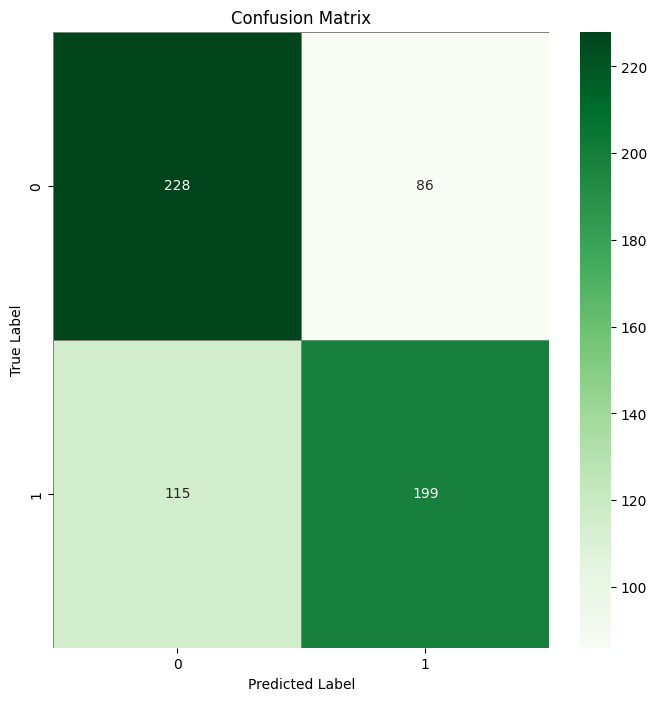

In [11]:
loss_eval_tuner, acc_eval_tuner = best_model.evaluate(X_test, labels_test, verbose=0)
print(f"Final Evaluation - Loss: {loss_eval:.4f}, Accuracy: {acc_eval:.4f}")

# Generate predictions: convert probabilities to 0 or 1 by thresholding at 0.5
predictions_tuner = best_model.predict(X_test)
pred_y_tuner = (predictions_tuner >= 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(labels_test, pred_y_tuner)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt='d', linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## LSTM CNN

In [22]:
def build_cnn_lstm_model():
    input_text = Input(shape=(max_sequence_length,))
    embedding = Embedding(input_dim=max_tokens, output_dim=256)(input_text)
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding)
    pool = MaxPooling1D(pool_size=2)(conv)
    lstm = LSTM(units=64, return_sequences=False)(pool)
    dropout = Dropout(rate=0.4)(lstm)
    dense = Dense(64, activation='relu')(dropout)
    output = Dense(1, activation='sigmoid')(dense)
    
    model = Model(inputs=input_text, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

cnn_lstm_model = build_cnn_lstm_model()
cnn_lstm_model.summary()

# Train
cnn_lstm_model.fit(X_train, labels_train, epochs=10, batch_size=16, validation_split=0.2)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 200, 256)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 198, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 99, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,712,065 (10.35 MB)

 Trainable params: 2,712,065 (10.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6347 - loss: 0.6764 - val_accuracy: 0.7209 - val_loss: 0.6284
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6193 - loss: 0.6175 - val_accuracy: 0.4729 - val_loss: 0.9657
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8906 - loss: 0.2934 - val_accuracy: 0.5891 - val_loss: 1.3244
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9663 - loss: 0.1229 - val_accuracy: 0.5426 - val_loss: 1.2361
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9702 - loss: 0.1104 - val_accuracy: 0.7054 - val_loss: 0.8786
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9640 - loss: 0.0913 - val_accuracy: 0.7364 - val_loss: 1.0885
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9741 - loss: 0.0744 - val_accuracy: 0.7364 - val_loss: 1.2556
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9878 - loss: 0.0480 - val_accuracy: 0.6899 - v

Best Model - Loss: 1.9197, Accuracy: 0.6019
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


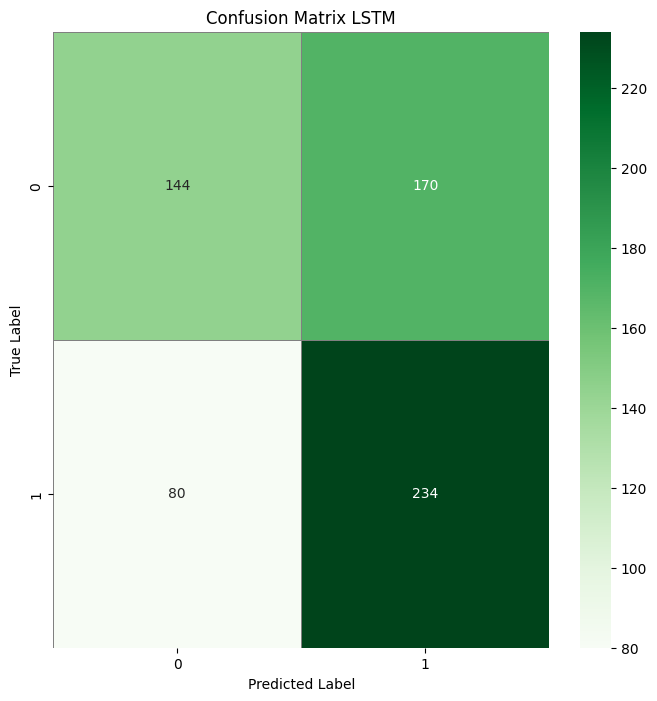

In [23]:
loss_eval_lstm, acc_eval_lstm = cnn_lstm_model.evaluate(X_test, labels_test, verbose=0)
print(f"Best Model - Loss: {loss_eval_lstm:.4f}, Accuracy: {acc_eval_lstm:.4f}")

predictions_lstm = cnn_lstm_model.predict(X_test)
pred_y_lstm = (predictions_lstm >= 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(labels_test, pred_y_lstm)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt='d', linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix LSTM")
plt.show()

## BERT CNN

In [25]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_bert(texts, max_len=256):
    return tokenizer(
        texts,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )

train_encodings = tokenize_bert(texts_train)
test_encodings = tokenize_bert(texts_test)

In [26]:
def build_bert_cnn_model():
    # Inputs
    input_ids = Input(shape=(256,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(256,), dtype=tf.int32, name="attention_mask")

    # Load BERT
    bert_model = TFBertModel.from_pretrained("bert-base-uncased")

    # Get BERT embeddings using Keras Lambda layer
    def get_bert_embeddings(inputs):
        return bert_model(inputs)[0]

    bert_output = tf.keras.layers.Lambda(
    get_bert_embeddings,
    output_shape=(256, 768)
    )({
        "input_ids": input_ids,
        "attention_mask": attention_mask
    })

    # CNN Layers
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(bert_output)
    pooled = GlobalMaxPooling1D()(conv)
    dense = Dense(64, activation='relu')(pooled)
    dropout = Dropout(0.4)(dense)
    output = Dense(1, activation='sigmoid')(dropout)

    # Build Model
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


bert_cnn_model = build_bert_cnn_model()
bert_cnn_model.summary()

# Train
bert_cnn_model.fit(
    x={"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    y=labels_train,
    epochs=3,
    batch_size=8,
    validation_split=0.1
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256, 768)  │          0 │ attention_mask[0… │
│                     │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 254, 128)  │    295,040 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_7[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      8,256 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         65 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 303,361 (1.16 MB)

 Trainable params: 303,361 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.4941 - loss: 0.8876 - val_accuracy: 0.7692 - val_loss: 0.5792
Epoch 2/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.7992 - loss: 0.4672 - val_accuracy: 0.8154 - val_loss: 0.4221
Epoch 3/3
73/73 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8536 - loss: 0.3388 - val_accuracy: 0.8462 - val_loss: 0.3885


20/20 ━━━━━━━━━━━━━━━━━━━━ 114s 6s/step - accuracy: 0.7911 - loss: 0.4739
Best Model - Loss: 0.4875, Accuracy: 0.7818
20/20 ━━━━━━━━━━━━━━━━━━━━ 115s 6s/step


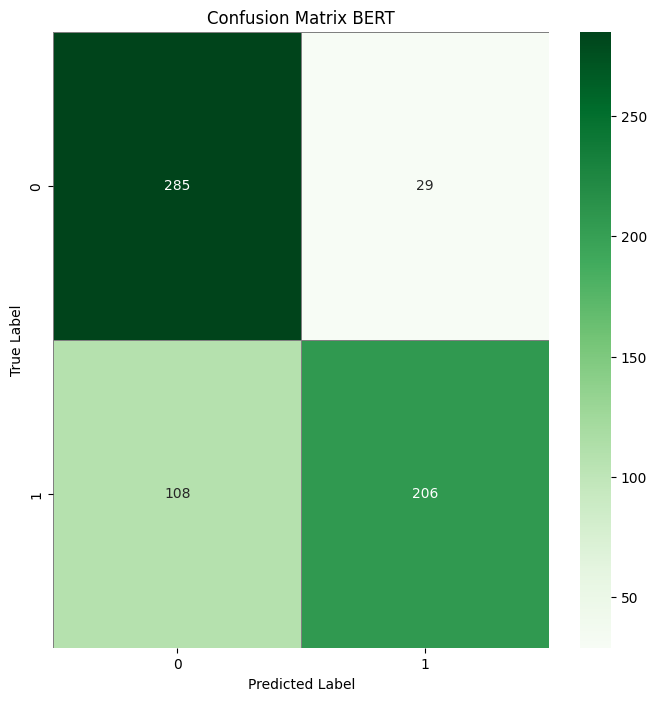

In [27]:
x_test = {
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"]
}

loss_eval_bert, acc_eval_bert = bert_cnn_model.evaluate(x=x_test, y=labels_test)
print(f"Best Model - Loss: {loss_eval_bert:.4f}, Accuracy: {acc_eval_bert:.4f}")

predictions_bert = bert_cnn_model.predict(x_test)
pred_y_bert = (predictions_bert >= 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(labels_test, pred_y_bert)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt='d', linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix BERT")
plt.show()

In [29]:
print("CNN Report:\n", classification_report(labels_test, pred_y))
print("CNN-Tuner Report:\n", classification_report(labels_test, pred_y_tuner))
print("CNN-LSTM Report:\n", classification_report(labels_test, pred_y_lstm))
print("CNN-Bert Report:\n", classification_report(labels_test, pred_y_bert))

CNN Report:
               precision    recall  f1-score   support

           0       0.64      0.84      0.73       314
           1       0.77      0.52      0.62       314

    accuracy                           0.68       628
   macro avg       0.70      0.68      0.67       628
weighted avg       0.70      0.68      0.67       628

CNN-Tuner Report:
               precision    recall  f1-score   support

           0       0.66      0.73      0.69       314
           1       0.70      0.63      0.66       314

    accuracy                           0.68       628
   macro avg       0.68      0.68      0.68       628
weighted avg       0.68      0.68      0.68       628

CNN-LSTM Report:
               precision    recall  f1-score   support

           0       0.64      0.46      0.54       314
           1       0.58      0.75      0.65       314

    accuracy                           0.60       628
   macro avg       0.61      0.60      0.59       628
weighted avg       0.61 